In [46]:
import caffe
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.datasets import mnist
from caffe.proto import caffe_pb2
import google.protobuf.text_format
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline

Using TensorFlow backend.


Loading the model

In [2]:
model_def = 'example_caffe_mnist_model.prototxt'
model_weights = 'mnist.caffemodel'
net = caffe.Net(model_def, model_weights, caffe.TEST)

A Caffe net offers a layer dict that maps layer names to layer objects. These objects do not provide very much information though, but access to their weights and the type of the layer.

In [3]:
net.layer_dict

OrderedDict([('data', <caffe._caffe.Layer at 0x7f6b341ca500>),
             ('conv2d_1', <caffe._caffe.Layer at 0x7f6afd78d818>),
             ('relu1', <caffe._caffe.Layer at 0x7f6afd78d768>),
             ('max_pooling2d_1', <caffe._caffe.Layer at 0x7f6afd78d7c0>),
             ('conv2d_2', <caffe._caffe.Layer at 0x7f6afd78d8c8>),
             ('relu2', <caffe._caffe.Layer at 0x7f6afd78d920>),
             ('dropout_1', <caffe._caffe.Layer at 0x7f6afd78d978>),
             ('dense_1', <caffe._caffe.Layer at 0x7f6afd78da28>),
             ('relu3', <caffe._caffe.Layer at 0x7f6afd78d710>),
             ('dropout_2', <caffe._caffe.Layer at 0x7f6afd78d6b8>),
             ('dense_2', <caffe._caffe.Layer at 0x7f6afd78d870>),
             ('loss', <caffe._caffe.Layer at 0x7f6afd78dad8>)])

In [6]:
conv_layer = net.layer_dict['conv2d_1']
conv_layer.type, conv_layer.blobs[0].data.shape

('Convolution', (32, 1, 3, 3))

### Getting input and output shape.
The net provides a `blobs dict`. These blobs contain `data`, i.e. all the intermediary computation results and `diff`, i.e. the gradients. 

In [19]:
for name, blob in net.blobs.items():
    print('{}: \t {}'.format(name, blob.data.shape))

data: 	 (64, 1, 28, 28)
label: 	 (64,)
conv2d_1: 	 (64, 32, 26, 26)
max_pooling2d_1: 	 (64, 32, 13, 13)
conv2d_2: 	 (64, 32, 11, 11)
dropout_1: 	 (64, 32, 11, 11)
dense_1: 	 (64, 64)
dropout_2: 	 (64, 64)
dense_2: 	 (64, 10)
loss: 	 ()


### Getting the weigths.
The net provides access to a `param dict` that contains the weights. The first entry in param corresponds to the weights, the second corresponds to the bias.

In [10]:
net.params

OrderedDict([('conv2d_1', <caffe._caffe.BlobVec at 0x7f6af8ef60d0>),
             ('conv2d_2', <caffe._caffe.BlobVec at 0x7f6af8ef6170>),
             ('dense_1', <caffe._caffe.BlobVec at 0x7f6af8ef6210>),
             ('dense_2', <caffe._caffe.BlobVec at 0x7f6af8ef62b0>)])

In [23]:
for name, param in net.params.items():
    print('{}:\t {} \t{}'.format(name, param[0].data.shape, param[1].data.shape))

conv2d_1:	 (32, 1, 3, 3) 	(32,)
conv2d_2:	 (32, 32, 3, 3) 	(32,)
dense_1:	 (64, 3872) 	(64,)
dense_2:	 (10, 64) 	(10,)


The weights are also accessible through the layer blobs.

In [24]:
for layer in net.layers:
    try:
        print (layer.type + '\t' + str(layer.blobs[0].data.shape), str(layer.blobs[1].data.shape))
    except:
        continue
    

Convolution	(32, 1, 3, 3) (32,)
Convolution	(32, 32, 3, 3) (32,)
InnerProduct	(64, 3872) (64,)
InnerProduct	(10, 64) (10,)


In [29]:
weights = net.params['conv2d_1'][0].data
weights.shape

(32, 1, 3, 3)

For visualizing the weights the axis still have to be moved around.

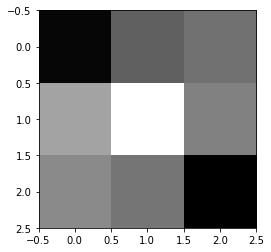

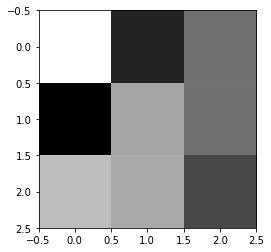

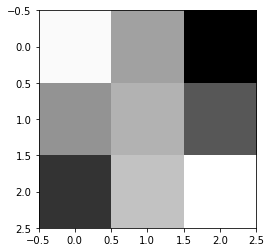

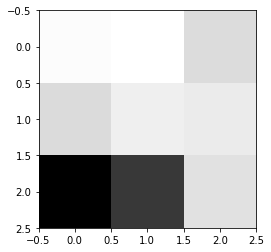

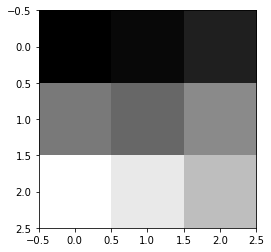

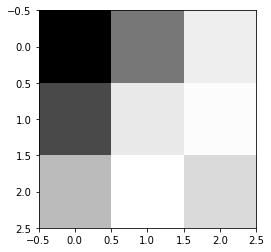

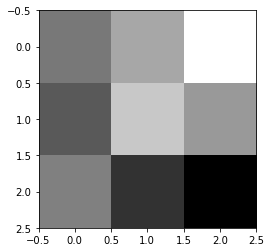

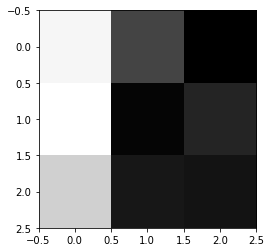

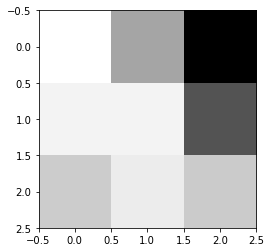

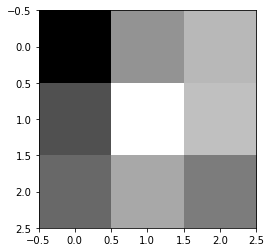

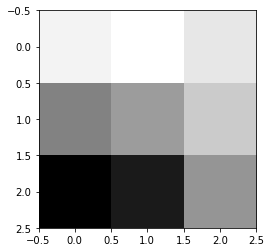

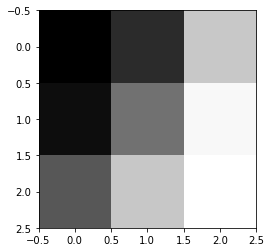

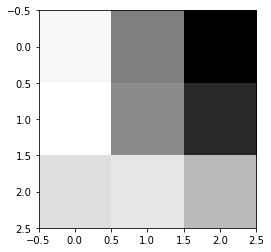

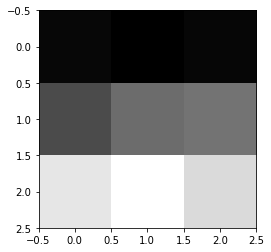

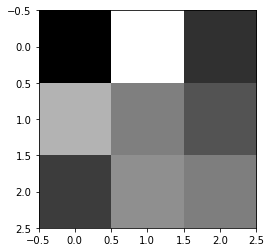

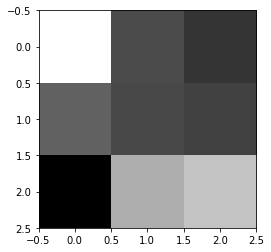

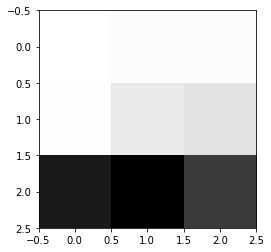

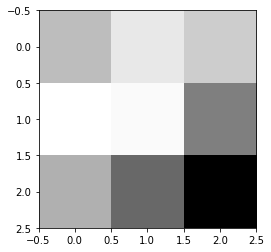

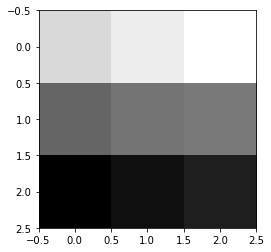

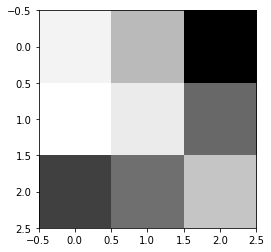

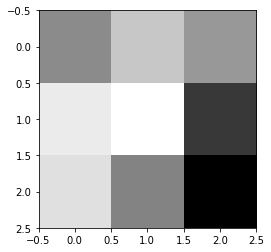

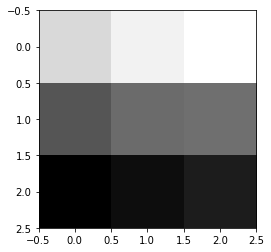

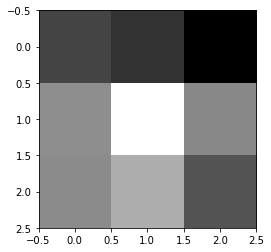

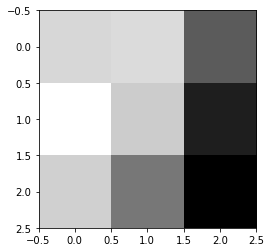

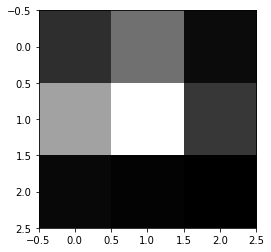

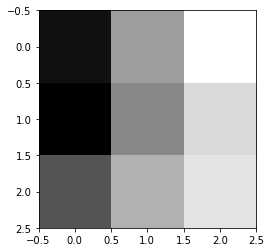

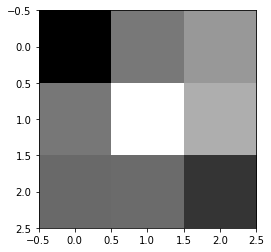

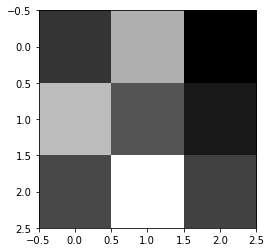

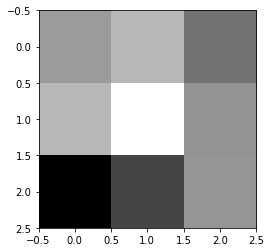

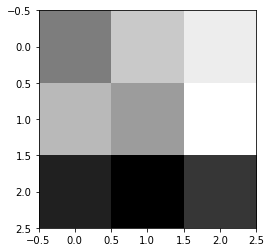

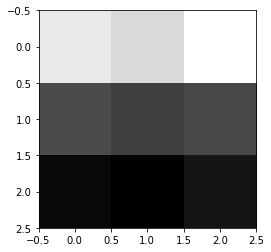

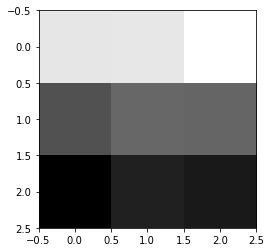

In [36]:
for i in range(32):
    plt.imshow(np.moveaxis(weights[i], 0, -1)[..., 0])
    plt.show()

Layers that have no weights simply keep empty lists as their blob vector.

In [27]:
list(net.layer_dict['dropout_1'].blobs)

[]

### Getting the activations and the net input.
For getting activations, first data has to be passed through the network. Then the activations can be read out from the blobs. If the activations are defined as in place operations, the net input will not be stored in any blob and can therefore not be recovered. This problem can be circumvented if the network definition is changed so that in place operations are avoided. This can also be done programatically as follows.

In [40]:
def remove_inplace(model_def):
    protonet = caffe_pb2.NetParameter()
    with open(model_def, 'r') as fp:
        google.protobuf.text_format.Parse(str(fp.read()), protonet)
        
    replaced_tops = {}
    for layer in protonet.layer:
        # Check whehter bottoms were renamed.
        for i in range(len(layer.bottom)):
            if layer.bottom[i] in replaced_tops.keys():
                layer.bottom[i] = replaced_tops[layer.bottom[i]]
                
            
        if layer.bottom == layer.top:
            for i in range(len(layer.top)):
                # Retain the mapping from the old to the new name.
                new_top = layer.top[i] + '_' + layer.name
                replaced_tops[layer.top[i]] = new_top
                # Redefine layer.top
                layer.top[i] = new_top
            
    return protonet

model_def = 'example_caffe_mnist_model_deploy.prototxt'

protonet_no_inplace = remove_inplace(model_def)
protonet_no_inplace

name: "ExampleCaffeMNISTModelDeploy"
layer {
  name: "data"
  type: "Input"
  top: "data"
  input_param {
    shape {
      dim: 64
      dim: 1
      dim: 28
      dim: 28
    }
  }
}
layer {
  name: "conv2d_1"
  type: "Convolution"
  bottom: "data"
  top: "conv2d_1"
  convolution_param {
    num_output: 32
    kernel_size: 3
    stride: 1
  }
}
layer {
  name: "relu_1"
  type: "ReLU"
  bottom: "conv2d_1"
  top: "conv2d_1_relu_1"
}
layer {
  name: "max_pooling2d_1"
  type: "Pooling"
  bottom: "conv2d_1_relu_1"
  top: "max_pooling2d_1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "conv2d_2"
  type: "Convolution"
  bottom: "max_pooling2d_1"
  top: "conv2d_2"
  convolution_param {
    num_output: 32
    kernel_size: 3
    stride: 1
  }
}
layer {
  name: "relu_2"
  type: "ReLU"
  bottom: "conv2d_2"
  top: "conv2d_2_relu_2"
}
layer {
  name: "dropout_1"
  type: "Dropout"
  bottom: "conv2d_2_relu_2"
  top: "dropout_1"
}
layer {
  name: "dense_1"
  t

In [38]:
model_def = 'example_caffe_network_no_inplace_deploy.prototxt'
model_weights = 'mnist.caffemodel'
net_no_inplace = caffe.Net(model_def, model_weights, caffe.TEST)

In [22]:
net_no_inplace.layer_dict

OrderedDict([('data', <caffe._caffe.Layer at 0x7f3a7157d978>),
             ('conv2d_1', <caffe._caffe.Layer at 0x7f3a70dd8450>),
             ('relu_1', <caffe._caffe.Layer at 0x7f3a70dd83f8>),
             ('max_pooling2d_1', <caffe._caffe.Layer at 0x7f3a70dd83a0>),
             ('conv2d_2', <caffe._caffe.Layer at 0x7f3a70dd8348>),
             ('relu_2', <caffe._caffe.Layer at 0x7f3a70dd82f0>),
             ('dropout_1', <caffe._caffe.Layer at 0x7f3a70dd8298>),
             ('dense_1', <caffe._caffe.Layer at 0x7f3a70dd80e0>),
             ('dropout_2', <caffe._caffe.Layer at 0x7f3a70dd8240>),
             ('dense_2', <caffe._caffe.Layer at 0x7f3a70dd8088>),
             ('prob', <caffe._caffe.Layer at 0x7f3a70dd84a8>)])

In [25]:
net_no_inplace.blobs

OrderedDict([('data', <caffe._caffe.Blob at 0x7f3a70dd8c90>),
             ('conv2d_1', <caffe._caffe.Blob at 0x7f3a70dd8ce8>),
             ('relu_1', <caffe._caffe.Blob at 0x7f3a70dd8558>),
             ('max_pooling2d_1', <caffe._caffe.Blob at 0x7f3a70dd86b8>),
             ('conv2d_2', <caffe._caffe.Blob at 0x7f3a70dd8608>),
             ('relu_2', <caffe._caffe.Blob at 0x7f3a70dd8a80>),
             ('dropout_1', <caffe._caffe.Blob at 0x7f3a70dd8be0>),
             ('dense_1', <caffe._caffe.Blob at 0x7f3a70dd8b30>),
             ('dropout_2', <caffe._caffe.Blob at 0x7f3a70dd8978>),
             ('dense_2', <caffe._caffe.Blob at 0x7f3a70dd8a28>),
             ('prob', <caffe._caffe.Blob at 0x7f3a70dd8d98>)])

(28, 28)
(1, 28, 28)


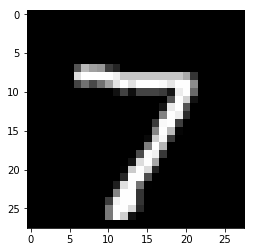

In [47]:
# Loading and preprocessing data.
data = mnist.load_data()[1][0]
# Normalize data.
data = data / data.max()
plt.imshow(data[0, :, :])
seven = data[0, :, :]
print(seven.shape)
seven = seven[np.newaxis, ...]
print(seven.shape)

Feeding the input and forwarding it.

In [49]:
net_no_inplace.blobs['data'].data[...] = seven
output = net_no_inplace.forward()
output['prob'][0].argmax()

7

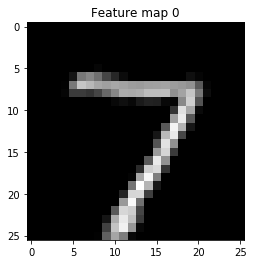

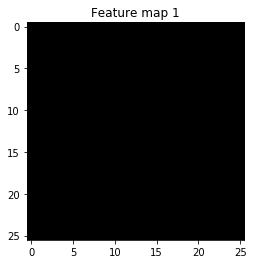

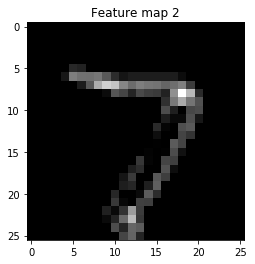

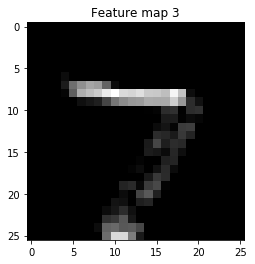

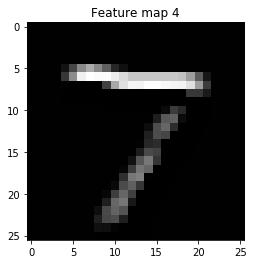

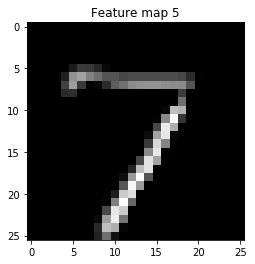

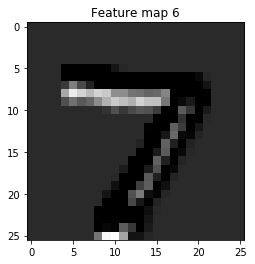

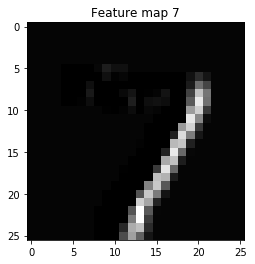

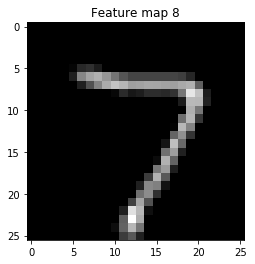

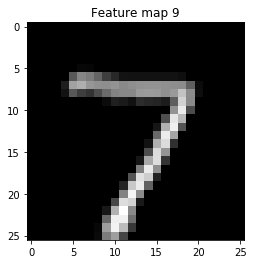

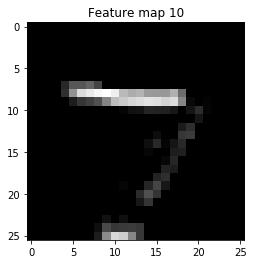

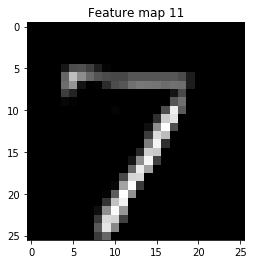

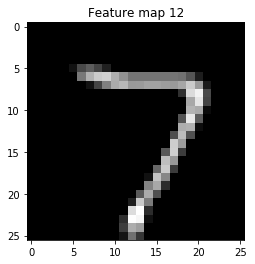

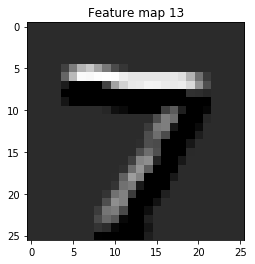

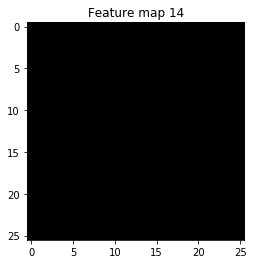

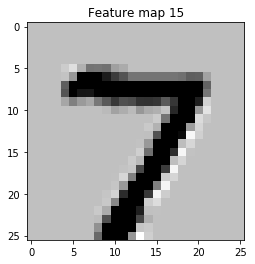

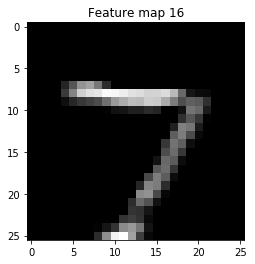

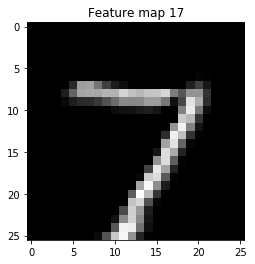

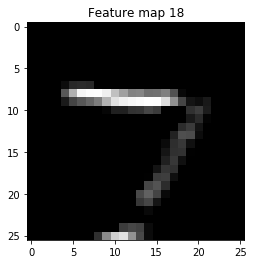

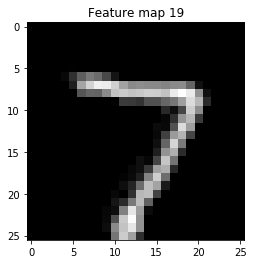

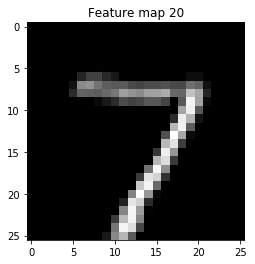

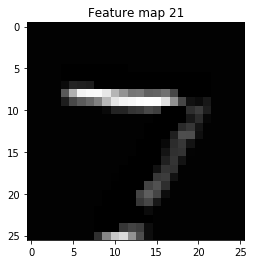

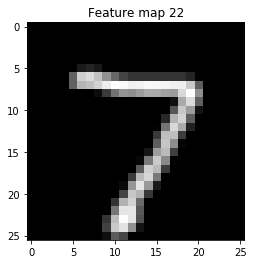

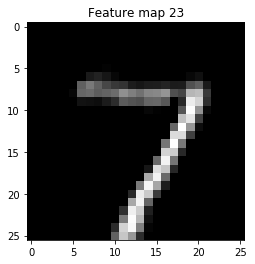

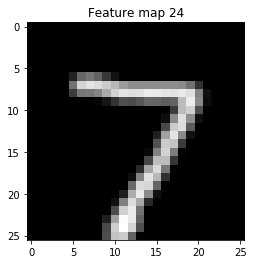

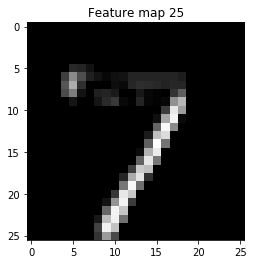

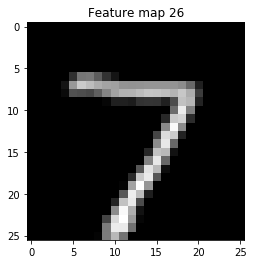

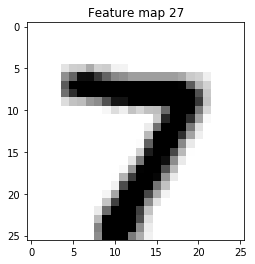

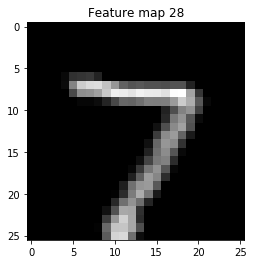

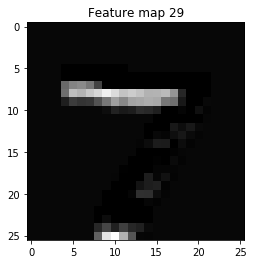

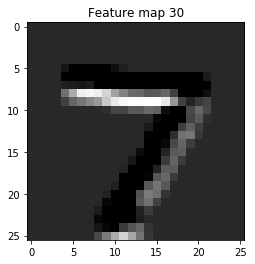

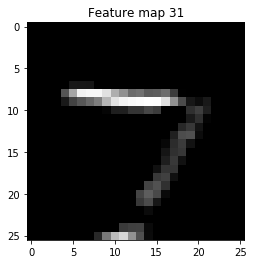

In [50]:
activations = net_no_inplace.blobs['relu_1'].data

for i in range(32):
    plt.imshow(activations[0, i, :, :])
    plt.title('Feature map %d' % i)
    plt.show()

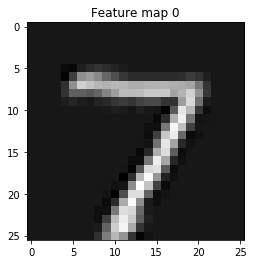

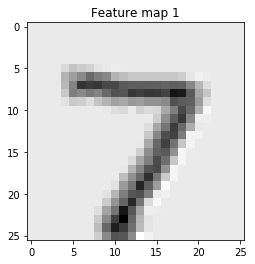

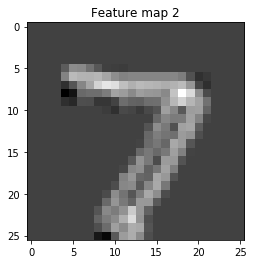

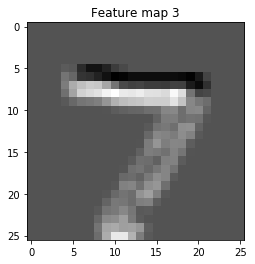

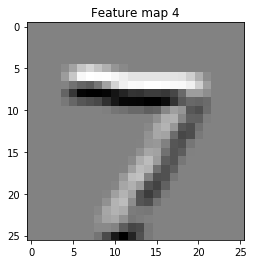

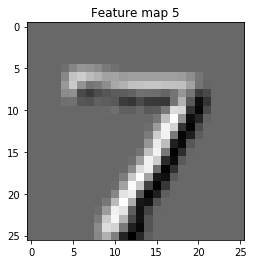

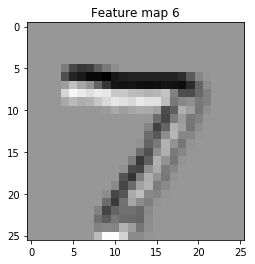

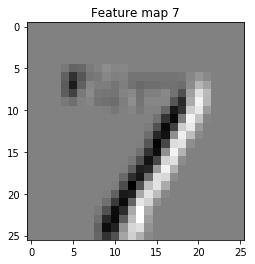

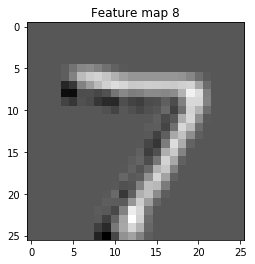

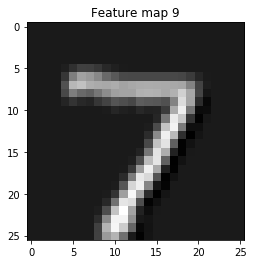

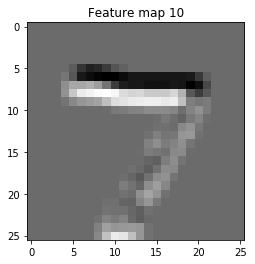

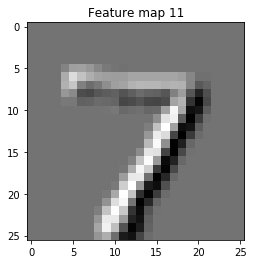

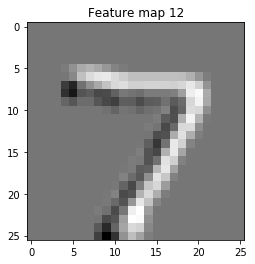

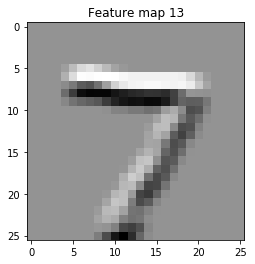

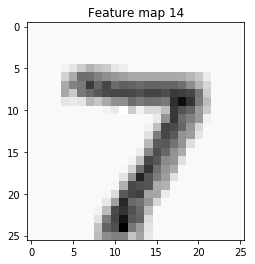

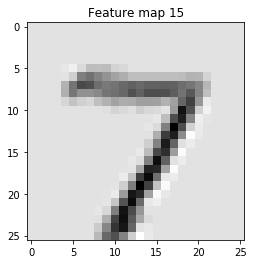

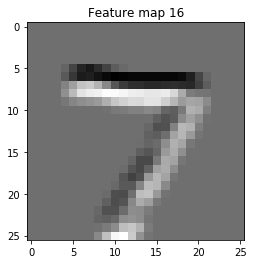

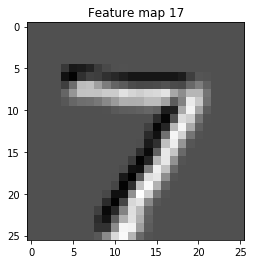

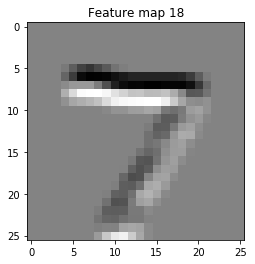

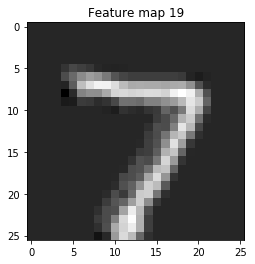

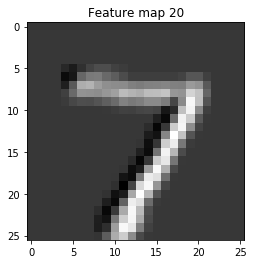

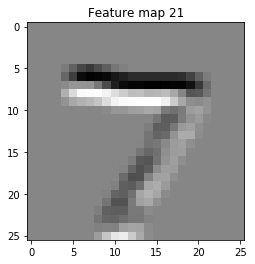

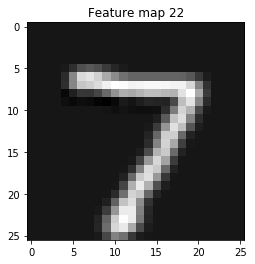

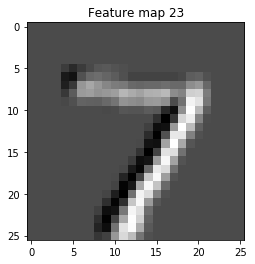

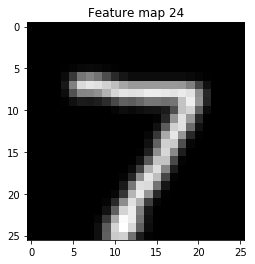

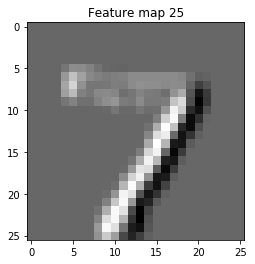

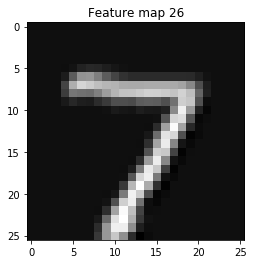

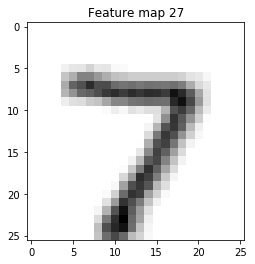

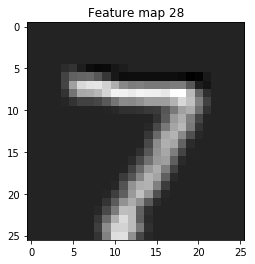

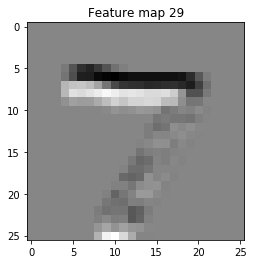

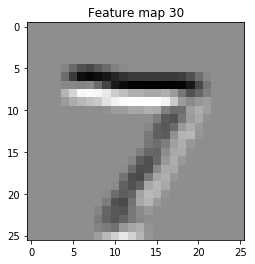

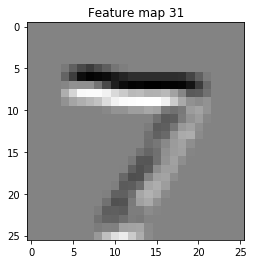

In [51]:
net_input = net_no_inplace.blobs['conv2d_1'].data

for i in range(32):
    plt.imshow(net_input[0, i, :, :])
    plt.title('Feature map %d' % i)
    plt.show()

### Getting layer properties
From the layer object not more then type information is available. There the original .prototxt has to be parsed to access attributes such as kernel size.

In [55]:
model_def = 'example_caffe_mnist_model.prototxt'
f = open(model_def, 'r')
protonet = caffe_pb2.NetParameter()
google.protobuf.text_format.Parse(str(f.read()), protonet)
f.close()
protonet

name: "ExampleCaffeMNISTModel"
layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.003921568859368563
  }
  data_param {
    source: "/work/rbusche/datasets/mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv2d_1"
  type: "Convolution"
  bottom: "data"
  top: "conv2d_1"
  convolution_param {
    num_output: 32
    kernel_size: 3
    stride: 1
    weight_filler {
      type: "gaussian"
      std: 0.009999999776482582
    }
    bias_filler {
      type: "constant"
      value: 0.0
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv2d_1"
  top: "conv2d_1"
}
layer {
  name: "max_pooling2d_1"
  type: "Pooling"
  bottom: "conv2d_1"
  top: "max_pooling2d_1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "conv2d_2"
  type: "Convolution"
  bottom: "max_pooling2d_1"
  top: "conv2d_2"
  convolution_param {
    num_output: 32
    kernel_size: 3
    stride: 1
 

In [56]:
type(protonet)

caffe_pb2.NetParameter

Parsed messages for the layer can be found in `message.layer` list.

In [57]:
for i in range(0, len(protonet.layer)):
    if protonet.layer[i].type == 'Convolution':
        print('layer %s has kernel_size %d' 
              % (protonet.layer[i].name, 
                 protonet.layer[i].convolution_param.kernel_size[0]))
        lconv_proto = protonet.layer[i]

layer conv2d_1 has kernel_size 3
layer conv2d_2 has kernel_size 3


In [58]:
len(protonet.layer), len(net.layers)

(12, 12)